In [1]:
import json
from types import *
from dataloader import *
from graphs import *
from scoring import *

# Allows interactive plotting
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', preprocess=True)

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'vinayak', 'vishnesh', 'anton', 'rachel', 'ayush', 'kelly'}

Couldn't process grammar for annotation: ['positive', '', '', '']
Couldn't process grammar for annotation: ['positive', 'minor', '', '']
Couldn't process grammar for annotation: ['positive', 'a lot', '', '']
Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']
Couldn't process grammar for annotation: ['positive', 'somewhat', '', '']
Couldn't process grammar for annotation: ['positive', 'a lot', '', '']
Couldn't process grammar for annotation: ['positive', 'minor', '', '']


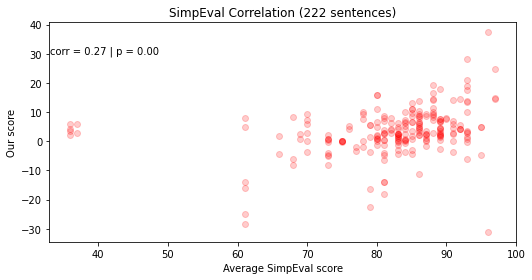

In [2]:
# Graph agreement with SimpEval
data = calculate_sentence_scores(data)
simpeval_agreement(data)

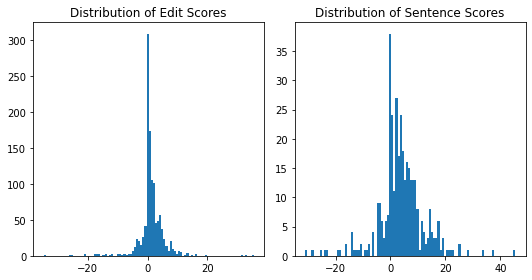

In [3]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [4]:
# This is my first time using iPy, so this is a bit clunky...
def series(
    data, 
    average, 
    user,
    good_deletion=default_params['good_deletion'], 
    good_trivial_insertion=default_params['good_trivial_insertion'], 
    good_insertion=default_params['good_insertion'], 
    good_paraphrase=default_params['good_paraphrase'], 
    good_syntax=default_params['good_syntax'], 
    grammar_error=default_params['grammar_error'], 
    content_error=default_params['content_error'], 
    size_calculation=default_params['size_calculation'],
    display_distribution=False
    ):
    params = {
        'good_deletion': good_deletion,
        'good_trivial_insertion': good_trivial_insertion,
        'good_insertion': good_insertion,
        'good_paraphrase': good_paraphrase,
        'good_syntax': good_syntax,
        'grammar_error': grammar_error,
        'content_error': content_error,
        'size_calculation': size_calculation
    }

    selected_data = data
    if user != 'all':
        selected_data = [sent for sent in selected_data if sent['user'] == user]

    selected_data = calculate_sentence_scores(selected_data, params)
    simpeval_agreement(selected_data, average)
    if (display_distribution):
        score_distribution(selected_data)
    return()

interact(
    series, 
    data=[data], 
    good_deletion=(-20,20,0.5), 
    good_trivial_insertion=(-20,20,0.5), 
    good_insertion=(-20,20,0.5), 
    good_paraphrase=(-20,20,0.5), 
    good_syntax=(-20,20,0.5), 
    grammar_error=(-20,20,0.5), 
    content_error=(-20,20,0.5),
    size_calculation=['linear', 'log', 'square', 'none'],
    average=[True, False],
    user=['all'] + sorted(list(set([sent['user'] for sent in data]))),
    display_distribution=[True, False]
)

interactive(children=(Dropdown(description='data', options=([{'id': 0, 'original': 'The wounds inflicted by a …

<function __main__.series(data, average, user, good_deletion=7, good_trivial_insertion=8, good_insertion=2, good_paraphrase=2, good_syntax=6, grammar_error=-1.5, content_error=-2, size_calculation='log', display_distribution=False)>